<a href="https://colab.research.google.com/github/srJboca/segmentacion/blob/main/EN/2.%20First%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Predicting Late Payments on Gas Invoices

## Introduction

This notebook is a continuation of the data exploration tutorial. Here, we will use the `df_analisis.parquet` DataFrame (previously cleaned and enriched) to build a Machine Learning model capable of predicting whether an invoice will be paid late (i.e., if it will be paid after the due date).

**Objective:** Predict the `Mora` variable.

**Steps we will follow:**
1.  Load data and libraries.
2.  Perform a quick review and final data preparation for modeling.
3.  Select features and the target variable.
4.  Encode categorical variables.
5.  Split data into training and testing sets.
6.  Train a Classification model (Random Forest).
7.  Evaluate the model (Accuracy, Classification Report, Confusion Matrix).
8.  Analyze feature importance.
9.  Discuss results and next steps.

## 1. Environment Setup and Data Loading

### 1.1 Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder # Although we'll prefer manual encoding for Estrato

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

### 1.2 Downloading and Loading the Preprocessed DataFrame

We will use the `df_analisis.parquet` file, which was the result of the data exploration and preparation notebook.

In [2]:
!wget -N https://github.com/srJboca/segmentacion/raw/refs/heads/main/archivos/df_analisis.parquet
df_analysis_original = pd.read_parquet('df_analisis.parquet')

--2025-06-13 13:56:29--  https://github.com/srJboca/segmentacion/raw/refs/heads/main/archivos/df_analisis.parquet
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/srJboca/segmentacion/refs/heads/main/archivos/df_analisis.parquet [following]
--2025-06-13 13:56:29--  https://raw.githubusercontent.com/srJboca/segmentacion/refs/heads/main/archivos/df_analisis.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75105565 (72M) [application/octet-stream]
Saving to: ‘df_analisis.parquet’

df_analisis.parquet 100%[===================>]  71.63M  98.3MB/s    in 0.7s    

Last-modified header missing -- 

## 2. Quick Review and Final Data Preparation

In [3]:
print("--- First 5 rows of df_analysis_original ---")
print(df_analysis_original.head())
print("\n--- Information of df_analysis_original ---")
df_analysis_original.info()
print("\n--- Present columns ---")
print(df_analysis_original.columns.tolist())

--- First 5 rows of df_analysis_original ---
                      Numero de factura                    Numero de contrato  \
0  886199bb-77c8-43e2-86a0-a53348fa2706  ba70b7fa-aef4-492a-9d45-13a0c63ce47c   
1  886199bb-77c8-43e2-86a0-a53348fa2706  ba70b7fa-aef4-492a-9d45-13a0c63ce47c   
2  6848b692-4212-4738-a35c-1f8c0d383e3d  ba70b7fa-aef4-492a-9d45-13a0c63ce47c   
3  ad91361e-9b8d-491e-bef9-e690e9b28faf  ba70b7fa-aef4-492a-9d45-13a0c63ce47c   
4  e77f7ac6-734b-4856-a5c3-1a32d845e6b6  ba70b7fa-aef4-492a-9d45-13a0c63ce47c   

  Fecha de Emision  Consumo (m3) Fecha de Pago Oportuno Fecha de Lectura  \
0       2021-01-06         11.51             2021-01-19       2020-12-28   
1       2021-01-06         11.51             2021-01-19       2020-12-28   
2       2021-03-02         10.26             2021-03-17       2021-02-20   
3       2021-04-01         14.96             2021-04-11       2021-03-27   
4       2021-05-10         14.89             2021-05-21       2021-05-05   

  Fecha de 

**Observations:**
* The loaded DataFrame (`df_analisis.parquet`) might have two columns related to late payments: `mora` (lowercase) and `Mora` (uppercase). This is an artifact of how the file was saved in the previous notebook. The `Mora` (uppercase) column was the one we created with the defined logic (1 if `Dias_PagoOportuno_PagoReal > 0`, 0 otherwise).
* We will ensure we use the correct `Mora` column and remove the redundant one if it exists.

In [4]:
df_modeling = df_analysis_original.copy()

# Check if both 'mora' and 'Mora' columns exist
if 'mora' in df_modeling.columns and 'Mora' in df_modeling.columns:
    print("Both 'mora' and 'Mora' columns exist. Will proceed to use 'Mora' and drop 'mora'.")
    # Before dropping, we could verify if they are identical or which one is correct
    # We assume 'Mora' (uppercase) is the one intentionally calculated.
    df_modeling = df_modeling.drop(columns=['mora'])
elif 'mora' in df_modeling.columns and 'Mora' not in df_modeling.columns:
    print("Only the 'mora' column exists. It will be renamed to 'Mora'.")
    df_modeling = df_modeling.rename(columns={'mora': 'Mora'})

print("\n--- Columns after handling 'mora'/'Mora' ---")
print(df_modeling.columns.tolist())

Both 'mora' and 'Mora' columns exist. Will proceed to use 'Mora' and drop 'mora'.

--- Columns after handling 'mora'/'Mora' ---
['Numero de factura', 'Numero de contrato', 'Fecha de Emision', 'Consumo (m3)', 'Fecha de Pago Oportuno', 'Fecha de Lectura', 'Fecha de Suspension Estimada', 'Ciudad', 'Estrato', 'Precio m3 (COP)', 'Fecha de Pago Real', 'Precio por Consumo', 'Dias_Emision_PagoOportuno', 'Dias_Lectura_Emision', 'Dias_PagoOportuno_PagoReal', 'Mora']


## 3. Feature and Target Variable Selection

We will select the features that we will use to predict the `Mora` variable (target).

**Important Note on Data Leakage:**
The `Dias_PagoOportuno_PagoReal` column is calculated using `Fecha de Pago Real` and `Fecha de Pago Oportuno`. The `Mora` variable is defined directly from the sign of `Dias_PagoOportuno_PagoReal`. Therefore, **we must NOT use `Dias_PagoOportuno_PagoReal` as a feature** to predict `Mora`, as this would constitute data leakage and the model would learn a trivial relationship, showing artificially perfect performance.

Initial candidate features from the original notebook:
`Consumo (m3)`, `Estrato`, `Precio por Consumo`, `Dias_Emision_PagoOportuno`, `Dias_Lectura_Emision`.

In [5]:
# Columns for the model, excluding identifiers and the column that causes leakage
selected_features = [
    'Consumo (m3)',
    'Estrato', # This is the original socioeconomic stratum column.
    'Precio por Consumo',
    'Dias_Emision_PagoOportuno',
    'Dias_Lectura_Emision'
]
target = 'Mora'

# Ensure that 'Estrato socioeconomico' is named 'Estrato' if necessary
if 'Estrato socioeconomico' in df_modeling.columns and 'Estrato' not in selected_features:
    if 'Estrato' not in df_modeling.columns: # Only rename if 'Estrato' doesn't exist
         df_modeling = df_modeling.rename(columns={'Estrato socioeconomico': 'Estrato'})
    elif 'Estrato' in df_modeling.columns and 'Estrato socioeconomico' in df_modeling.columns:
         # If both exist, and 'Estrato' is from df_gas_prices, use 'Estrato socioeconomico'
         # and ensure that 'Estrato' in selected_features refers to the correct one.
         # For simplicity, we assume that df_analisis.parquet already has the correct 'Estrato' column (the socioeconomic one).
         pass # Assume 'Estrato' is already the correct socioeconomic column.

df_prediction = df_modeling[selected_features + [target]].copy()

print("--- DataFrame for prediction (df_prediction) ---")
print(df_prediction.head())
print("\n--- Data types in df_prediction ---")
df_prediction.info()

--- DataFrame for prediction (df_prediction) ---
   Consumo (m3)    Estrato  Precio por Consumo  Dias_Emision_PagoOportuno  \
0         11.51  Estrato 1             6767.88                         13   
1         11.51  Estrato 1             6767.88                         13   
2         10.26  Estrato 1             6032.88                         15   
3         14.96  Estrato 1             9529.52                         10   
4         14.89  Estrato 1             9484.93                         11   

   Dias_Lectura_Emision  Mora  
0                     9     0  
1                     9     0  
2                    10     0  
3                     5     0  
4                     5     0  

--- Data types in df_prediction ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400000 entries, 0 to 2399999
Data columns (total 6 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Consumo (m3)               float64
 1   Estrato               

## 4. Preprocessing for the Model

### 4.1 Encoding the 'Estrato' Variable

The `Estrato` variable is categorical (e.g., 'Estrato 1', 'Estrato 2'). Machine Learning models require numerical inputs. We will convert 'Estrato' to an ordinal numerical type, as the strata have an inherent order.

In [6]:
if df_prediction['Estrato'].dtype == 'object' or isinstance(df_prediction['Estrato'].dtype, pd.CategoricalDtype):
    print("Encoding 'Estrato' from object/categorical to numeric type.")
    try:
        df_prediction['Estrato'] = df_prediction['Estrato'].str.replace('Estrato ', '', regex=False).astype(int)
    except AttributeError:
        # If it's already numeric (e.g., if the parquet has it as a number but read as category)
        df_prediction['Estrato'] = df_prediction['Estrato'].astype(str).str.replace('Estrato ', '', regex=False).astype(int)
else:
    print("'Estrato' is already numeric.")
    df_prediction['Estrato'] = df_prediction['Estrato'].astype(int) # Ensure it is int

print("\n--- 'Estrato' after encoding ---")
print(df_prediction[['Estrato']].head())
print(df_prediction['Estrato'].value_counts())

Encoding 'Estrato' from object/categorical to numeric type.

--- 'Estrato' after encoding ---
   Estrato
0        1
1        1
2        1
3        1
4        1
Estrato
2    844080
3    600912
1    596256
4    240576
5     60192
6     57984
Name: count, dtype: int64


### 4.2 Handling Missing Values (NaN)

We check for missing values in the selected features. For this tutorial, if there are only a few, we might drop them or use simple imputation. Models like RandomForest can handle NaNs in some implementations, but it's good practice to address them.

In [7]:
print("--- Missing values in df_prediction before handling ---")
print(df_prediction.isnull().sum())

# Simple strategy: drop rows with NaNs in features or the target
# (Consider imputation for a more complex real-world case)
df_prediction_final = df_prediction.dropna()

print(f"\nOriginal shape: {df_prediction.shape}")
print(f"Shape after dropna: {df_prediction_final.shape}")
print("\n--- Missing values in df_prediction_final after handling ---")
print(df_prediction_final.isnull().sum())

--- Missing values in df_prediction before handling ---
Consumo (m3)                 0
Estrato                      0
Precio por Consumo           0
Dias_Emision_PagoOportuno    0
Dias_Lectura_Emision         0
Mora                         0
dtype: int64

Original shape: (2400000, 6)
Shape after dropna: (2400000, 6)

--- Missing values in df_prediction_final after handling ---
Consumo (m3)                 0
Estrato                      0
Precio por Consumo           0
Dias_Emision_PagoOportuno    0
Dias_Lectura_Emision         0
Mora                         0
dtype: int64


### 4.3 Defining X (Features) and y (Target Variable)

In [8]:
X = df_prediction_final.drop(target, axis=1)
y = df_prediction_final[target]

print("--- Features (X) ---")
print(X.head())
print("\n--- Target Variable (y) ---")
print(y.head())
print("\nDistribution of the target variable 'Mora':")
print(y.value_counts(normalize=True))

--- Features (X) ---
   Consumo (m3)  Estrato  Precio por Consumo  Dias_Emision_PagoOportuno  \
0         11.51        1             6767.88                         13   
1         11.51        1             6767.88                         13   
2         10.26        1             6032.88                         15   
3         14.96        1             9529.52                         10   
4         14.89        1             9484.93                         11   

   Dias_Lectura_Emision  
0                     9  
1                     9  
2                    10  
3                     5  
4                     5  

--- Target Variable (y) ---
0    0
1    0
2    0
3    0
4    0
Name: Mora, dtype: int64

Distribution of the target variable 'Mora':
Mora
0    0.74985
1    0.25015
Name: proportion, dtype: float64


The distribution of the target variable `Mora` tells us if there is a class imbalance. If one class is much more frequent than the other, we might need special techniques (like `class_weight='balanced'` in the model or over/under-sampling).

## 5. Splitting Data: Training and Testing

We split the data into a training set (for the model to learn from) and a testing set (to evaluate its performance on unseen data).
We use `stratify=y` to ensure that the proportion of classes in `Mora` is similar in both sets.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Size of X_train: {X_train.shape}")
print(f"Size of X_test: {X_test.shape}")
print(f"Size of y_train: {y_train.shape}")
print(f"Size of y_test: {y_test.shape}")

print("\nProportion of 'Mora' in y_train:")
print(y_train.value_counts(normalize=True))
print("\nProportion of 'Mora' in y_test:")
print(y_test.value_counts(normalize=True))

Size of X_train: (1920000, 5)
Size of X_test: (480000, 5)
Size of y_train: (1920000,)
Size of y_test: (480000,)

Proportion of 'Mora' in y_train:
Mora
0    0.749851
1    0.250149
Name: proportion, dtype: float64

Proportion of 'Mora' in y_test:
Mora
0    0.74985
1    0.25015
Name: proportion, dtype: float64


## 6. Training the Model (Random Forest Classifier)

We will use a `RandomForestClassifier`. It's a robust and popular ensemble model.
The `class_weight='balanced'` parameter helps the model treat the classes more equally if there is an imbalance.

In [10]:
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)
print("RandomForestClassifier model trained.")

RandomForestClassifier model trained.


## 7. Evaluating the Model

We will evaluate the model on the test set using several metrics:

--- Evaluation Results ---
Accuracy: 0.6624

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78    359928
           1       0.30      0.26      0.28    120072

    accuracy                           0.66    480000
   macro avg       0.53      0.53      0.53    480000
weighted avg       0.65      0.66      0.65    480000


Confusion Matrix:
[[287020  72908]
 [ 89134  30938]]


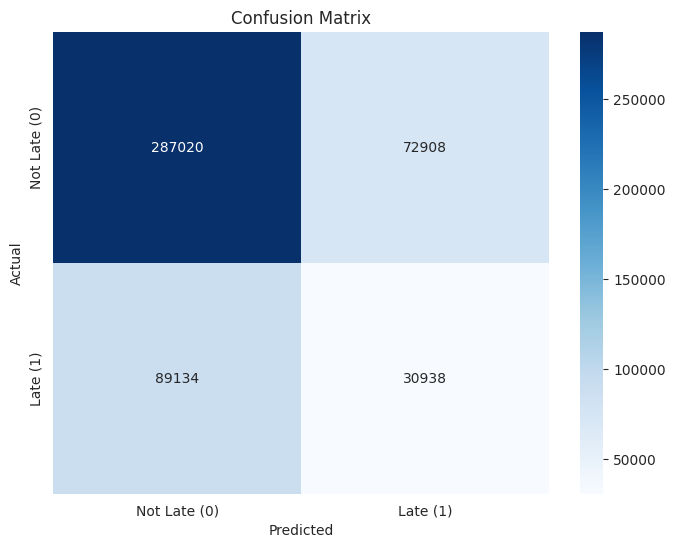

In [11]:
y_pred = model.predict(X_test)

print("--- Evaluation Results ---")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualizing the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Late (0)', 'Late (1)'], yticklabels=['Not Late (0)', 'Late (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Interpreting the Metrics:**
* **Accuracy:** Proportion of correct predictions. Can be misleading if classes are imbalanced.
* **Classification Report:**
    * **Precision:** Of all the predictions for a class, how many were correct? (TP / (TP + FP)). Important if the cost of a False Positive is high.
    * **Recall:** Of all the actual instances of a class, how many were correctly identified? (TP / (TP + FN)). Important if the cost of a False Negative is high (e.g., failing to detect an invoice that will be paid late).
    * **F1-score:** Harmonic mean of Precision and Recall. A good overall indicator of performance, especially with imbalanced classes.
    * **Support:** The number of actual instances of each class.
* **Confusion Matrix:**
    * **True Negatives (TN):** 'Not Late' cases correctly predicted as 'Not Late'.
    * **False Positives (FP):** 'Not Late' cases incorrectly predicted as 'Late' (Type I Error).
    * **False Negatives (FN):** 'Late' cases incorrectly predicted as 'Not Late' (Type II Error).
    * **True Positives (TP):** 'Late' cases correctly predicted as 'Late'.

## 8. Feature Importance

Random Forest allows us to see which features were most influential in the prediction.

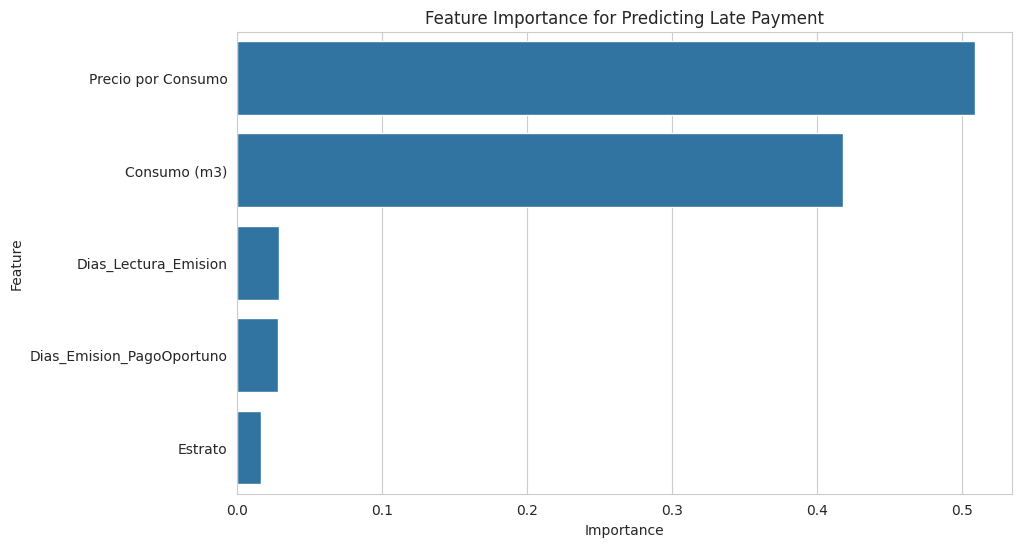

                     Feature  Importance
2         Precio por Consumo    0.509303
0               Consumo (m3)    0.417888
4       Dias_Lectura_Emision    0.028493
3  Dias_Emision_PagoOportuno    0.028252
1                    Estrato    0.016063


In [12]:
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance for Predicting Late Payment')
plt.show()

print(feature_importance_df)

**Interpreting Feature Importance:**
This shows us which factors the model considers most decisive in determining whether an invoice will be paid late. It can guide business decisions or future refinements of the model.

## 9. Discussion of Results and Next Steps

**Questions for Discussion:**
* Is the accuracy good? How are precision/recall for the 'Mora=1' class? Which features are the most important?
* Is the model (Random Forest) good, average, or poor for predicting late payments under the current conditions and with the selected features?
* It's crucial to remember that data leakage was avoided by not including `Dias_PagoOportuno_PagoReal`.

**Limitations and Considerations:**
* **Data Quality:** The model's performance depends on the quality and representativeness of the input data.
* **Feature Engineering:** More features could be explored (e.g., customer payment history, variations in consumption, etc.).
* **Class Balance:** If the 'Mora=1' class is a minority, accuracy may not be the best metric. F1-score, recall for the minority class, or AUC-ROC (not calculated here) are more informative.
* **Simplification:** A simple strategy for handling NaNs was used. More sophisticated methods might be necessary.

**Potential Next Steps:**
* **Hyperparameter Tuning:** Use techniques like GridSearchCV or RandomizedSearchCV to find the best combination of hyperparameters for the RandomForest.
* **Try Other Models:** Evaluate other algorithms (e.g., Logistic Regression, Gradient Boosting, SVM).
* **Advanced Feature Engineering:** Create more complex or domain-specific variables.
* **Error Analysis:** Investigate the cases where the model makes mistakes (False Positives and False Negatives) to understand its weaknesses.
* **Deployment to Production:** If the model is satisfactory, plan how it would be integrated into a system to make predictions on new invoices.

This tutorial provides a foundation for late payment prediction. Modeling is an iterative process of experimentation and improvement.